In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load from the baseline module's data folder
train = pd.read_csv("../baseline_prophet_forecast/data/train.csv")
features = pd.read_csv("../baseline_prophet_forecast/data/features.csv")
stores = pd.read_csv("../baseline_prophet_forecast/data/stores.csv")

df = (
    train
    .merge(features, on=["Store", "Date"])
    .merge(stores, on="Store")
)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Dept", "Date"])
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [15]:
store = 1
dept = 1

ts = (
    df[(df["Store"] == store) & (df["Dept"] == dept)]
    [["Date", "Weekly_Sales", "IsHoliday_x"]]
    .rename(columns={"Date": "ds", "Weekly_Sales": "y", "IsHoliday_x": "IsHoliday"})
    .sort_values("ds")
)

ts = ts.set_index("ds")
# Remove asfreq - it creates NaN values when dates don't align with weekly boundaries
ts

,y,IsHoliday
ds,,
2010-02-05,24924.50,False
2010-02-12,46039.49,True
2010-02-19,41595.55,False
2010-02-26,19403.54,False
2010-03-05,21827.90,False
...,...,...
2012-09-28,18947.81,False
2012-10-05,21904.47,False
2012-10-12,22764.01,False


In [16]:
window = 8

ts["rolling_mean"] = ts["y"].rolling(window).mean()
ts["rolling_std"] = ts["y"].rolling(window).std()

ts["z_score"] = (ts["y"] - ts["rolling_mean"]) / ts["rolling_std"]

# Flag anomalies (spikes or dips)
threshold = 2.0
ts["anomaly"] = ts["z_score"].abs() > threshold

ts.dropna(inplace=True)
ts.head()


,y,IsHoliday,rolling_mean,rolling_std,z_score,anomaly
ds,,,,,,
2010-03-26,26229.21,False,27900.02750,10124.538627,-0.165027,False
2010-04-02,57258.43,False,31941.76875,14342.348043,1.765169,False
2010-04-09,42960.91,False,31556.94625,13945.873195,0.817730,False
2010-04-16,17596.96,False,28557.12250,14058.692100,-0.779600,False
2010-04-23,16145.35,False,28149.84875,14404.685813,-0.833375,False


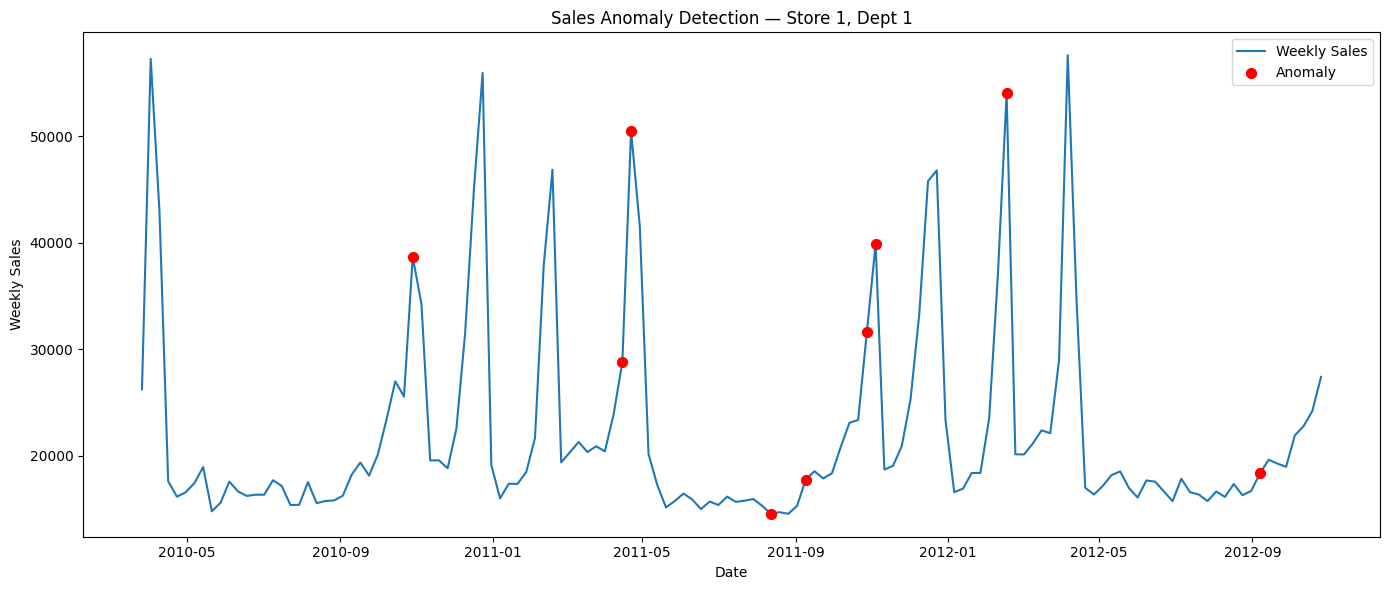

In [17]:
plt.figure(figsize=(14, 6))

plt.plot(ts.index, ts["y"], label="Weekly Sales", linewidth=1.5)

anoms = ts[ts["anomaly"]]

plt.scatter(
    anoms.index,
    anoms["y"],
    color="red",
    label="Anomaly",
    s=50,
    zorder=3,
)

plt.title(f"Sales Anomaly Detection — Store {store}, Dept {dept}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.savefig("images/anomaly_series_store1_dept1.png")
plt.show()


In [19]:
anomaly_table = anoms[["y", "z_score", "IsHoliday"]].copy()
anomaly_table = anomaly_table.rename(columns={"y": "Weekly_Sales"})

anomaly_table


,Weekly_Sales,z_score,IsHoliday
ds,,,
2010-10-29,38640.93,2.160687,False
2011-04-15,28762.37,2.233622,False
2011-04-22,50510.31,2.377021,False
2011-08-12,14539.79,-2.047728,False
2011-09-09,17746.68,2.142930,True
2011-10-28,31579.90,2.167489,False
2011-11-04,39886.06,2.026131,False
2012-02-17,54060.10,2.133512,False
2012-09-07,18322.37,2.024349,True


In [ ]:
anomaly_table.to_csv("../../artifacts/anomalies_store1_dept1.csv")

Interpretation
- Points flagged with |z-score| > 2 are considered statistically unusual given an 8-week rolling window.
- Positive anomalies often correspond to holiday or promotion periods, where demand spikes above typical levels.
- Negative anomalies may indicate stockouts, supply issues, or data/reporting problems, and should be investigated by operations or replenishment teams.
- This logic can be extended across all store–department combinations as part of a monitoring layer in production.